<a href="https://colab.research.google.com/github/PaoDeV99/ML_Progetto1_G72/blob/master/GradientBoosting_%26_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Gradient Boosting Classifier**

Conduciamo una prima analisi con la funzione *GradientBoostingClassifier* implementata nella libreria SciKitLearn. <br/>
Importiamo il file di dati *miniBooNE_PID.txt*, precedentemente caricato su Google Drive, e creiamo un dataset *df* con *pandas*.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_fwf('/content/drive/My Drive/Colab Notebooks/MiniBooNE_PID.txt')

In [4]:
df

,36499 93565,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49
0,2.59413,0.468803,20.6916,0.322648,0.009682,0.374393,0.803479,0.896592,3.59665,0.249282,4.18624,135.885000,0.928671,0.140918,2.58663,1689.070,1.197950,19.35610,0.398340,0.658684,1.561270,0.320885,108.8560,5.16994,0.491493,0.868283,29.6141,1.222990,0.190005,-0.654163,4.97666,0.908007,0.385076,377.412,0.136108,0.310650,2.952640,-4.55567,0.934167,0.049752,101.174,-31.37300,0.442259,5.86453,0.000000,0.090519,0.176909,0.457585,0.071769,0.245996
1,3.86388,0.645781,18.1375,0.233529,0.030733,0.361239,1.069740,0.878714,3.59243,0.200793,4.65578,331.718000,0.882784,0.368855,2.24638,1388.260,0.839230,6.69510,0.277778,0.944626,1.664640,0.256501,102.4930,5.33218,0.474294,-0.336652,31.5767,1.317170,0.141945,0.093886,5.05478,1.394390,0.325034,215.837,0.082048,0.297530,0.777241,-4.76871,1.438210,0.068714,186.516,45.95970,-0.478507,6.11126,0.001182,0.091800,-0.465572,0.935523,0.333613,0.230621
2,3.38584,1.197140,36.0807,0.200866,0.017341,0.260841,1.108950,0.884405,3.43159,0.177167,4.50807,159.396000,0.412250,0.434002,2.38485,992.098,0.514175,16.00300,0.256262,0.318984,-0.727361,0.312139,69.8362,3.44976,0.497076,-0.314786,59.2516,1.187650,0.192565,-0.511144,5.27196,1.002860,1.690870,417.430,0.068628,0.220612,1.390970,-2.02213,1.843790,0.085132,129.931,-11.56080,-0.297008,8.27204,0.003854,0.141721,-0.210559,1.013450,0.255512,0.180901
3,4.28524,0.510155,674.2010,0.281923,0.009174,0.000000,0.998822,0.823390,3.16382,0.171678,4.08041,-1.865600,0.833067,0.181294,2.49837,1289.160,0.630307,12.93740,0.266055,1.313580,0.698101,0.306193,148.0340,4.12461,0.494778,0.331151,17.8265,1.700340,0.147487,0.313964,7.91668,1.584410,0.557134,352.699,0.079246,0.338915,-0.331218,-3.52184,1.244390,0.105550,163.978,-18.45860,0.453886,2.48112,0.000000,0.180938,0.407968,4.341270,0.473081,0.258990
4,5.93662,0.832993,59.8796,0.232853,0.025066,0.233556,1.370040,0.787424,3.66546,0.174862,4.59180,183.668000,0.398421,0.353034,2.04136,949.231,0.389585,13.91750,0.281003,0.282402,-0.039672,0.233509,106.8670,2.94245,0.464260,-0.033102,139.4700,1.687930,0.117804,0.021927,7.80990,1.317420,0.677348,317.556,0.041526,0.249403,-0.360560,-3.18766,1.808670,0.105852,229.555,42.96000,-0.975752,2.66109,0.000000,0.170836,-0.814403,4.679490,1.924990,0.253893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130059,4.80718,1.451020,174.6920,0.343481,0.002174,0.000000,0.747401,0.725617,3.18501,0.152208,4.09329,-0.707947,0.813344,0.015294,1.83104,520.017,0.192353,7.59299,0.271739,0.580181,2.706590,0.321739,18.9165,4.77587,0.488641,0.578023,106.1100,1.827670,0.174318,0.523787,7.59281,1.451220,0.616285,453.588,0.015260,0.291661,-0.445277,-3.02319,1.513750,0.055040,179.832,-2.74376,0.317051,2.67617,0.000000,0.141958,0.723207,7.446300,3.219320,0.299487
130060,5.00527,1.501860,129.9270,0.273477,0.006098,0.109769,1.325370,0.830334,3.40836,0.130794,4.23870,49.729900,0.527637,0.337350,2.32783,779.822,0.295920,12.35990,0.280488,1.630800,-0.447177,0.302846,64.8961,2.66737,0.443424,-0.060302,149.7250,1.565400,0.138097,0.199993,7.29614,1.130380,1.100050,414.089,0.072055,0.288639,0.780298,-2.74524,1.216240,0.110098,120.794,-24.72180,0.312652,4.16524,0.000000,0.232273,0.141153,1.898750,1.778180,0.258058
130061,3.10842,2.178140,56.3651,0.211850,0.000000,0.167382,1.318900,0.870681,

In [5]:
col_names=[]
for i in range(1,51):
  col_names.append('Feature '+ str(i))

df.columns = col_names
df

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,Feature 11,Feature 12,Feature 13,Feature 14,Feature 15,Feature 16,Feature 17,Feature 18,Feature 19,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,Feature 30,Feature 31,Feature 32,Feature 33,Feature 34,Feature 35,Feature 36,Feature 37,Feature 38,Feature 39,Feature 40,Feature 41,Feature 42,Feature 43,Feature 44,Feature 45,Feature 46,Feature 47,Feature 48,Feature 49,Feature 50
0,2.59413,0.468803,20.6916,0.322648,0.009682,0.374393,0.803479,0.896592,3.59665,0.249282,4.18624,135.885000,0.928671,0.140918,2.58663,1689.070,1.197950,19.35610,0.398340,0.658684,1.561270,0.320885,108.8560,5.16994,0.491493,0.868283,29.6141,1.222990,0.190005,-0.654163,4.97666,0.908007,0.385076,377.412,0.136108,0.310650,2.952640,-4.55567,0.934167,0.049752,101.174,-31.37300,0.442259,5.86453,0.000000,0.090519,0.176909,0.457585,0.071769,0.245996
1,3.86388,0.645781,18.1375,0.233529,0.030733,0.361239,1.069740,0.878714,3.59243,0.200793,4.65578,331.718000,0.882784,0.368855,2.24638,1388.260,0.839230,6.69510,0.277778,0.944626,1.664640,0.256501,102.4930,5.33218,0.474294,-0.336652,31.5767,1.317170,0.141945,0.093886,5.05478,1.394390,0.325034,215.837,0.082048,0.297530,0.777241,-4.76871,1.438210,0.068714,186.516,45.95970,-0.478507,6.11126,0.001182,0.091800,-0.465572,0.935523,0.333613,0.230621
2,3.38584,1.197140,36.0807,0.200866,0.017341,0.260841,1.108950,0.884405,3.43159,0.177167,4.50807,159.396000,0.412250,0.434002,2.38485,992.098,0.514175,16.00300,0.256262,0.318984,-0.727361,0.312139,69.8362,3.44976,0.497076,-0.314786,59.2516,1.187650,0.192565,-0.511144,5.27196,1.002860,1.690870,417.430,0.068628,0.220612,1.390970,-2.02213,1.843790,0.085132,129.931,-11.56080,-0.297008,8.27204,0.003854,0.141721,-0.210559,1.013450,0.255512,0.180901
3,4.28524,0.510155,674.2010,0.281923,0.009174,0.000000,0.998822,0.823390,3.16382,0.171678,4.08041,-1.865600,0.833067,0.181294,2.49837,1289.160,0.630307,12.93740,0.266055,1.313580,0.698101,0.306193,148.0340,4.12461,0.494778,0.331151,17.8265,1.700340,0.147487,0.313964,7.91668,1.584410,0.557134,352.699,0.079246,0.338915,-0.331218,-3.52184,1.244390,0.105550,163.978,-18.45860,0.453886,2.48112,0.000000,0.180938,0.407968,4.341270,0.473081,0.258990
4,5.93662,0.832993,59.8796,0.232853,0.025066,0.233556,1.370040,0.787424,3.66546,0.174862,4.59180,183.668000,0.398421,0.353034,2.04136,949.231,0.389585,13.91750,0.281003,0.282402,-0.039672,0.233509,106.8670,2.94245,0.464260,-0.033102,139.4700,1.687930,0.117804,0.021927,7.80990,1.317420,0.677348,317.556,0.041526,0.249403,-0.360560,-3.18766,1.808670,0.105852,229.555,42.96000,-0.975752,2.66109,0.000000,0.170836,-0.814403,4.679490,1.924990,0.253893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130059,4.80718,1.451020,174.6920,0.343481,0.002174,0.000000,0.747401,0.725617,3.18501,0.152208,4.09329,-0.707947,0.813344,0.015294,1.83104,520.017,0.192353,7.59299,0.271739,0.580181,2.706590,0.321739,18.9165,4.77587,0.488641,0.578023,106.1100,1.827670,0.174318,0.523787,7.59281,1.451220,0.616285,453.588,0.015260,0.291661,-0.445277,-3.02319,1.513750,0.055040,179.832,-2.74376,0.317051,2.67617,0.000000,0.141958,0.723207,7.446300,3.219320,0.299487
130060,5.00527,1.501860,129.9270,0.273477,0.006098,0.109769,1.325370,0.830334,3.40836,0.130794,4.23870,49.729900,0.527637,0.337350,2.32783,779.822,0.295920,12.35990,0.280488,1.630800,-0.447177,0.302846,64.8961,2.66737,0.443424,-0.060302,149.7250,1.565400,0.138097,0.199993,7.29614,1.130380,1.100050,414.089,0.072055,0.288639,0.780298,-2.74524,1.216240,0.110098,120.794,-24.72180,0.312652,4.16524,0.000000,0.232273,0.141153,1.898750,1.778180,0.258058
130061,3.10842,2.178140,56.3651,0.211850,0.000000,0.167382,1.318900,0.870681,3.43055,0.279588,4.29747,79.969100,0.744210,0.1724

Aggiungiamo una colonna al dataset, corrispondente alla classificazione che vogliamo ottenere. La nuova colonna *signal* conterrà il valore 1 per i primi 36499 eventi (corrispondenti al rilevamento di un segnale) e 0 per i successivi (associati al rumore sperimentale).

In [6]:
df["signal"]=0
df.iloc[0:36499,50]=1
df.iloc[36499:,50]=0
df

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,Feature 11,Feature 12,Feature 13,Feature 14,Feature 15,Feature 16,Feature 17,Feature 18,Feature 19,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,Feature 30,Feature 31,Feature 32,Feature 33,Feature 34,Feature 35,Feature 36,Feature 37,Feature 38,Feature 39,Feature 40,Feature 41,Feature 42,Feature 43,Feature 44,Feature 45,Feature 46,Feature 47,Feature 48,Feature 49,Feature 50,signal
0,2.59413,0.468803,20.6916,0.322648,0.009682,0.374393,0.803479,0.896592,3.59665,0.249282,4.18624,135.885000,0.928671,0.140918,2.58663,1689.070,1.197950,19.35610,0.398340,0.658684,1.561270,0.320885,108.8560,5.16994,0.491493,0.868283,29.6141,1.222990,0.190005,-0.654163,4.97666,0.908007,0.385076,377.412,0.136108,0.310650,2.952640,-4.55567,0.934167,0.049752,101.174,-31.37300,0.442259,5.86453,0.000000,0.090519,0.176909,0.457585,0.071769,0.245996,1
1,3.86388,0.645781,18.1375,0.233529,0.030733,0.361239,1.069740,0.878714,3.59243,0.200793,4.65578,331.718000,0.882784,0.368855,2.24638,1388.260,0.839230,6.69510,0.277778,0.944626,1.664640,0.256501,102.4930,5.33218,0.474294,-0.336652,31.5767,1.317170,0.141945,0.093886,5.05478,1.394390,0.325034,215.837,0.082048,0.297530,0.777241,-4.76871,1.438210,0.068714,186.516,45.95970,-0.478507,6.11126,0.001182,0.091800,-0.465572,0.935523,0.333613,0.230621,1
2,3.38584,1.197140,36.0807,0.200866,0.017341,0.260841,1.108950,0.884405,3.43159,0.177167,4.50807,159.396000,0.412250,0.434002,2.38485,992.098,0.514175,16.00300,0.256262,0.318984,-0.727361,0.312139,69.8362,3.44976,0.497076,-0.314786,59.2516,1.187650,0.192565,-0.511144,5.27196,1.002860,1.690870,417.430,0.068628,0.220612,1.390970,-2.02213,1.843790,0.085132,129.931,-11.56080,-0.297008,8.27204,0.003854,0.141721,-0.210559,1.013450,0.255512,0.180901,1
3,4.28524,0.510155,674.2010,0.281923,0.009174,0.000000,0.998822,0.823390,3.16382,0.171678,4.08041,-1.865600,0.833067,0.181294,2.49837,1289.160,0.630307,12.93740,0.266055,1.313580,0.698101,0.306193,148.0340,4.12461,0.494778,0.331151,17.8265,1.700340,0.147487,0.313964,7.91668,1.584410,0.557134,352.699,0.079246,0.338915,-0.331218,-3.52184,1.244390,0.105550,163.978,-18.45860,0.453886,2.48112,0.000000,0.180938,0.407968,4.341270,0.473081,0.258990,1
4,5.93662,0.832993,59.8796,0.232853,0.025066,0.233556,1.370040,0.787424,3.66546,0.174862,4.59180,183.668000,0.398421,0.353034,2.04136,949.231,0.389585,13.91750,0.281003,0.282402,-0.039672,0.233509,106.8670,2.94245,0.464260,-0.033102,139.4700,1.687930,0.117804,0.021927,7.80990,1.317420,0.677348,317.556,0.041526,0.249403,-0.360560,-3.18766,1.808670,0.105852,229.555,42.96000,-0.975752,2.66109,0.000000,0.170836,-0.814403,4.679490,1.924990,0.253893,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130059,4.80718,1.451020,174.6920,0.343481,0.002174,0.000000,0.747401,0.725617,3.18501,0.152208,4.09329,-0.707947,0.813344,0.015294,1.83104,520.017,0.192353,7.59299,0.271739,0.580181,2.706590,0.321739,18.9165,4.77587,0.488641,0.578023,106.1100,1.827670,0.174318,0.523787,7.59281,1.451220,0.616285,453.588,0.015260,0.291661,-0.445277,-3.02319,1.513750,0.055040,179.832,-2.74376,0.317051,2.67617,0.000000,0.141958,0.723207,7.446300,3.219320,0.299487,0
130060,5.00527,1.501860,129.9270,0.273477,0.006098,0.109769,1.325370,0.830334,3.40836,0.130794,4.23870,49.729900,0.527637,0.337350,2.32783,779.822,0.295920,12.35990,0.280488,1.630800,-0.447177,0.302846,64.8961,2.66737,0.443424,-0.060302,149.7250,1.565400,0.138097,0.199993,7.29614,1.130380,1.100050,414.089,0.072055,0.288639,0.780298,-2.74524,1.216240,0.110098,120.794,-24.72180,0.312652,4.16524,0.000000,0.232273,0.141153,1.898750,1.778180,0.258058,0
130061,3.10842,2.178140,56.3651,0.211850,0.000000,0.167382,1.318900,0.870681,3.43055,0.279588,4.29747,

Riordiniamo gli eventi in modo casuale, così che gli eventi di segnale e di rumore siano equamente distribuiti nel dataset. Dividiamo quindi il dataset in due campioni di dati (uno per il training dell'algoritmo ed uno per il test del classificatore, contenente la metà dei dati del campione di training).

In [7]:
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
 x_train, x_test, y_train, y_test = train_test_split(
   df.iloc[:,0:50], df["signal"], test_size=0.33, random_state=42)

Utilizziamo ora i campioni generati per addestrare l'algoritmo e testare le sue prestazioni, variando il numero di stimatori (ovvero il numero di alberi) utilizzato dal classificatore. Passiamo da un minimo di 100 ad un massimo di 1000 stimatori, mantenendo invariati il *learning rate* dell'algoritmo (0.1) ed il numero massimo di iterazioni che esso compie (100). <br/>
Grafichiamo quindi i valori di accuracy in fase di training e in fase di test al variare del numero di stimatori. In un secondo grafico, infine, riportiamo l'andamento del tempo di *run* dell'algoritmo al variare del numero di stimatori.

In [ ]:
estimators = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

m=len(estimators)
#n=len(leaf_size_list)

#Allocate Arrays for various quantities
gbc_train_accuracy=np.zeros((m))
gbc_test_accuracy=np.zeros((m))
run_time=np.zeros((m))

for i, nest in enumerate(estimators):
  # Define Gradient Boosting Classifier
  gbc = GradientBoostingClassifier(n_estimators=nest, min_samples_split=2, random_state=0, warm_start=True)
        
  print('n_estimators: %i'%(nest))
        
  start_time = time.time()
  gbc.fit(x_train, y_train)
  run_time[i] = time.time() - start_time    
    
  # check accuracy
  gbc_train_accuracy[i]=gbc.score(x_train,y_train)
  gbc_test_accuracy[i]=gbc.score(x_test,y_test)
  predictions = gbc.predict(x_test)
        
  result = (run_time[i], gbc_train_accuracy[i], gbc_test_accuracy[i])
  print('{0:<15}{1:<15}{2:<15}'.format("time (s)","train score", "test score"))
  print('{0:<15.4f}{1:<15.4f}{2:<15.4f}'.format(*result))
  print('\nConfusion matrix:')
  print(confusion_matrix(y_test, predictions))
  print('\n')

n_estimators: 100
time (s)       train score    test score     
194.9361       0.9320         0.9301         

Confusion matrix:
[[29395  1471]
 [ 1528 10528]]


n_estimators: 200
time (s)       train score    test score     
390.0535       0.9405         0.9356         

Confusion matrix:
[[29467  1399]
 [ 1365 10691]]


n_estimators: 300
time (s)       train score    test score     
583.8403       0.9446         0.9381         

Confusion matrix:
[[29505  1361]
 [ 1297 10759]]


n_estimators: 400
time (s)       train score    test score     
778.4319       0.9476         0.9397         

Confusion matrix:
[[29532  1334]
 [ 1254 10802]]


n_estimators: 500
time (s)       train score    test score     
979.1879       0.9503         0.9407         

Confusion matrix:
[[29554  1312]
 [ 1234 10822]]


n_estimators: 600
time (s)       train score    test score     
1182.4557      0.9527         0.9412         

Confusion matrix:
[[29572  1294]
 [ 1230 10826]]


n_estimators: 700
time (s)  

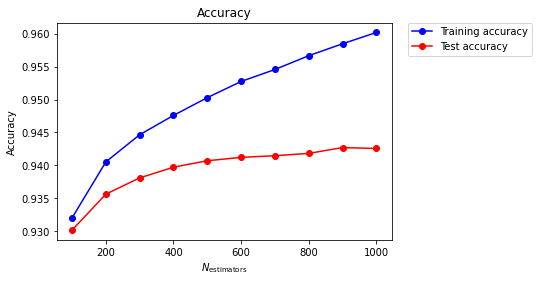

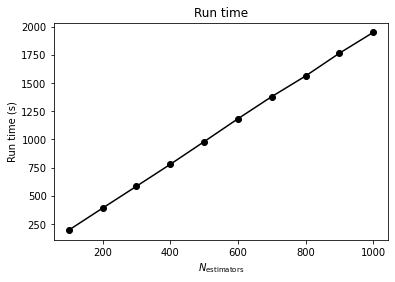

In [ ]:
plt.figure()
plt.plot(estimators,gbc_train_accuracy,'o-b', label='Training accuracy')
plt.plot(estimators,gbc_test_accuracy,'o-r', label='Test accuracy')

plt.title('Accuracy')
plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Accuracy')
lgd=plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("gbc.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

plt.plot(estimators, run_time, 'o-k')
plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Run time (s)')

plt.title('Run time')
#plt.legend(loc=2)
plt.savefig("runtimegbc.pdf")

plt.show()

Osserviamo che l'accuracy sul campione di training cresce molto più velocemente di quella relativa al campione di test. All'aumentare del numero di stimatori, dunque, l'algoritmo tende all'overfitting. Tuttavia, il risultato migliore (ottenuto con 900 stimatori e corrispondente ad una *training accuracy* del $95.85\%$ ed una *test accuracy* del $94.27\%$ costituiscono un risultato ottimo dal punto di vista della capacità di classificazione dell'algoritmo e, al contempo, non presentano un overfitting sufficientemente alto da lasciare dubbi sulla qualità della prestazione. <br/>
Sebbene ci si aspettasse di trovare il miglior risultato di accuracy utilizzando 1000 stimatori, esso è stato ottenuto con 900 alberi. Dato il repentino cambio di pendenza della curva dell'accuracy sul campione di test tra 800 e 900 stimatori e tra 900 e 1000 stimatori e osservando che la differenza tra i valori di accuracy relativi a 900 e 1000 stimatori è minima, si ritiene che il valore medio dell'accuracy ottenibile con 900 stimatori sia in realtà minore di quello dei 1000 stimatori. <br/>
Il secondo grafico mostra invece una chiara dipendenza lineare del tempo di *run* dell'algoritmo dal numero di stimatori utilizzati.

#**GBC senza outliers**

Si passa ora all'analisi del problema di classificazione nel caso in cui si escludano gli outliers dal dataset. Utilizzando lo *z-score* di ciascuna feature (ricavabile tramite l'omonima funzione di SciPy), si identificano gli outliers come tutti gli eventi per i quali il valore di almeno una feature disti più di 3 deviazioni standard dal valore medio della stessa.

In [ ]:
from scipy import stats
z = np.abs(stats.zscore(df))
print(z)

[[0.03832917 0.05484215 0.66315667 ... 0.02873009 0.06097846 1.60109178]
 [0.03265101 0.05784847 0.01191809 ... 0.03214799 0.0614603  0.62457381]
 [0.04033966 0.07795757 0.64554076 ... 0.03793908 0.05968592 1.60109178]
 ...
 [0.03449682 0.08090748 0.20594208 ... 0.03548535 0.05979431 1.60109178]
 [0.06898881 0.06499614 0.14127057 ... 0.07464638 0.05955436 0.62457381]
 [0.0494558  0.05280245 0.57646973 ... 0.06612587 0.05862323 1.60109178]]


In [ ]:
print(np.where(z > 3))

(array([    16,     27,     36, ..., 130055, 130061, 130061]), array([26, 15, 15, ..., 15, 15, 22]))


Si escludono quindi questi eventi dal dataset e riordiniamo gli altri, sempre con criterio casuale.

In [ ]:
df_o = df[(z < 3).all(axis=1)]
df_o = df_o.sample(frac=1).reset_index(drop=True)
df_o

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,Feature 11,Feature 12,Feature 13,Feature 14,Feature 15,Feature 16,Feature 17,Feature 18,Feature 19,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,Feature 30,Feature 31,Feature 32,Feature 33,Feature 34,Feature 35,Feature 36,Feature 37,Feature 38,Feature 39,Feature 40,Feature 41,Feature 42,Feature 43,Feature 44,Feature 45,Feature 46,Feature 47,Feature 48,Feature 49,Feature 50,signal
0,3.01665,1.100570,23.15420,0.241474,0.016043,0.406573,1.192370,0.854202,3.49374,0.228402,4.53363,359.166000,0.202845,0.332870,1.90371,843.344,0.497931,6.78759,0.315508,0.790253,0.796920,0.278075,46.1739,5.77278,0.476879,0.208241,6.64803,1.34598,0.151868,-0.230280,5.11511,1.067880,0.521551,235.407,0.121805,0.359067,0.829726,-3.87961,1.246740,0.057083,149.947,-4.385700,0.261867,4.49020,0.000000,0.073039,-0.176867,1.162150,-0.087372,0.222188,1
1,3.29344,1.888170,138.25600,0.316428,0.000000,0.123214,0.858411,0.858401,3.62532,0.189409,4.30637,110.192000,0.386811,0.195249,2.25068,670.703,0.304368,57.01320,0.330189,0.348457,-0.055751,0.273585,34.8261,3.81690,0.397845,0.316695,129.24300,1.20934,0.214384,-1.356680,5.72385,0.530082,1.525030,462.237,0.081613,0.294626,0.897409,-2.13700,1.113140,0.058479,105.637,-61.250300,1.579360,5.27115,0.000000,0.152810,-0.011370,1.281250,0.030862,0.177402,0
2,4.15362,1.087520,144.35000,0.279942,0.005952,0.139213,0.809727,0.764669,3.35533,0.142995,4.44018,428.941000,0.793579,0.373273,1.60817,763.882,0.404251,12.69190,0.238095,1.343460,-0.608531,0.267857,53.4773,4.09345,0.466754,-0.589107,159.29700,1.44380,0.128403,-0.183171,6.85602,1.440910,0.671279,146.051,0.103569,0.393920,0.559983,-3.60319,1.331510,0.081186,146.338,-24.895700,0.636275,5.17382,0.000000,0.141354,-0.153771,1.684760,0.173979,0.274579,0
3,6.08730,2.260540,122.55200,0.234924,0.002387,0.033403,0.874072,0.744004,3.67070,0.135357,4.71415,360.376000,0.972153,0.870290,1.65915,524.290,0.212751,14.74510,0.229117,0.963391,-4.838200,0.310263,50.4270,3.00641,0.456280,-3.573500,7.61322,1.48898,0.123375,-0.607338,7.14659,1.096800,2.196720,219.206,0.016931,0.362677,0.316847,-1.83680,1.228320,0.120745,134.590,-33.335900,1.083970,12.08770,0.069212,0.176849,-1.120980,2.425960,1.275240,0.240397,0
4,4.95638,0.993922,79.47530,0.321792,0.000000,0.191004,0.858918,0.806539,3.12866,0.167854,3.81538,202.943000,0.849668,0.083392,1.92438,785.148,0.335663,7.96290,0.262763,0.684626,2.214610,0.349850,74.7040,4.67304,0.447229,0.512881,81.46550,1.71700,0.188037,0.091541,8.57112,1.354600,0.663586,369.075,0.038791,0.307069,-0.222875,-3.34565,1.535040,0.104808,187.487,-17.941200,0.172111,2.79381,0.000000,0.155611,0.823337,5.974170,2.926880,0.253986,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123475,5.49395,1.037220,148.33000,0.338517,0.000000,0.101687,0.376244,0.840094,3.11154,0.099831,3.70977,84.051300,-0.219963,0.153787,2.13627,679.334,0.222835,30.42530,0.193359,0.584337,0.128312,0.283203,40.8925,1.97582,0.450896,-0.225487,205.23400,1.91694,0.130572,-0.231128,11.74120,0.660407,2.831660,453.262,0.015959,0.173543,-0.593140,-1.39478,1.271450,0.131198,159.767,-15.472300,0.335579,2.28298,0.000000,0.365733,0.277020,5.143370,1.915860,0.274257,0
123476,4.85185,1.856950,6.34943,0.269554,0.002481,0.000000,1.322480,0.841490,3.47665,0.116722,4.32271,-0.899475,0.453761,0.456141,2.39354,727.638,0.267940,14.08610,0.275434,0.951850,-0.233387,0.302730,71.2824,2.43941,0.496195,-1.103890,29.27580,1.37253,0.136531,-0.741830,7.01709,0.887962,1.713880,472.757,0.087794,0.339642,0.590527,-2.06064,1.252680,0.120101,105.804,-25.729500,2.289750,6.96137,0.000000,0.243725,0.133527,2.109140,1.283400,0.145394,0
123477,4.33102,1.531670,22.60920,0.262476,0.005597,0.260930,0.870853,0.809449,3.50233,0.

Si divide ancora il dataset in campioni di training e di test e si ripetono le operazioni effettuate in precedenza.

In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(
   df_o.iloc[:,0:50], df_o["signal"], test_size=0.33, random_state=42)

In [ ]:
estimators = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

m=len(estimators)
#n=len(leaf_size_list)

#Allocate Arrays for various quantities
gbc_train_accuracy_o=np.zeros((m))
gbc_test_accuracy_o=np.zeros((m))
run_time_o=np.zeros((m))

for i, nest in enumerate(estimators):
  # Define Gradient Boosting Classifier
  gbc = GradientBoostingClassifier(n_estimators=nest, min_samples_split=2, random_state=0, warm_start=True)
        
  print('n_estimators: %i'%(nest))
        
  start_time = time.time()
  gbc.fit(x_train_o, y_train_o)
  run_time_o[i] = time.time() - start_time    
    
  # check accuracy
  gbc_train_accuracy_o[i]=gbc.score(x_train_o,y_train_o)
  gbc_test_accuracy_o[i]=gbc.score(x_test_o,y_test_o)
  predictions_o = gbc.predict(x_test_o)
        
  result = (run_time_o[i], gbc_train_accuracy_o[i], gbc_test_accuracy_o[i])
  print('{0:<15}{1:<15}{2:<15}'.format("time (s)","train score", "test score"))
  print('{0:<15.4f}{1:<15.4f}{2:<15.4f}'.format(*result))
  print('\nConfusion matrix:')
  print(confusion_matrix(y_test_o, predictions_o))
  print('\n')

n_estimators: 100
time (s)       train score    test score     
183.2352       0.9333         0.9277         

Confusion matrix:
[[28929  1482]
 [ 1466  8872]]


n_estimators: 200
time (s)       train score    test score     
372.3264       0.9407         0.9334         

Confusion matrix:
[[29015  1396]
 [ 1319  9019]]


n_estimators: 300
time (s)       train score    test score     
557.6143       0.9451         0.9354         

Confusion matrix:
[[29047  1364]
 [ 1267  9071]]


n_estimators: 400
time (s)       train score    test score     
735.2965       0.9482         0.9369         

Confusion matrix:
[[29074  1337]
 [ 1233  9105]]


n_estimators: 500
time (s)       train score    test score     
932.1040       0.9509         0.9390         

Confusion matrix:
[[29113  1298]
 [ 1188  9150]]


n_estimators: 600
time (s)       train score    test score     
1111.2939      0.9533         0.9397         

Confusion matrix:
[[29141  1270]
 [ 1186  9152]]


n_estimators: 700
time (s)  

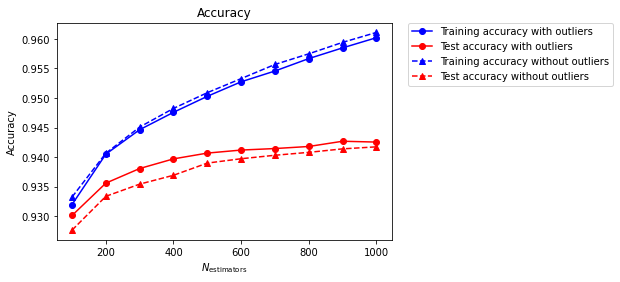

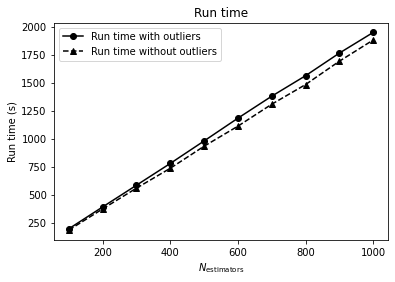

In [ ]:
plt.figure()
plt.plot(estimators,gbc_train_accuracy,'o-b', label='Training accuracy with outliers')
plt.plot(estimators,gbc_test_accuracy,'o-r', label='Test accuracy with outliers')
plt.plot(estimators,gbc_train_accuracy_o,'--b^', label='Training accuracy without outliers')
plt.plot(estimators,gbc_test_accuracy_o,'--r^', label='Test accuracy without outliers')

plt.title('Accuracy')
plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Accuracy')
lgd=plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("gbc_comp.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

plt.plot(estimators, run_time, 'o-k', label='Run time with outliers')
plt.plot(estimators, run_time_o, '--k^', label='Run time without outliers')

plt.title('Run time')
plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Run time (s)')
plt.legend(loc=2)
plt.savefig("runtimegbc_comp.pdf")

plt.show()

Si nota che, anche se di poco, la tendenza all'overfitting dell'algoritmo è accentuata: l'accuracy in fase di training, infatti, aumenta, mentre quella sul campione di training diminuisce. <br/>
Dovendo processare meno eventi, il tempo di esecuzione dell'algoritmo risulta ora minore.

#**Confronto tra diverse combinazioni di parametri**

Si studia ora la miglior combinazione di learning rate e numero di stimatori. La funzione *RandomizedSearchCV*, disponibile in SciKitLearn, permette di analizzare la performance dell'algoritmo con diversi valori di *learning rate* ed *estimators*, valutando per ogni combinazione la prestazione del regressore sul campione di test.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {"n_estimators": [100, 500, 1000],
              "learning_rate": [0.01,0.05,0.1]
             }

GBC = GradientBoostingClassifier(min_samples_split=2, random_state=0, warm_start=True)

start_time=time.time()
cv_inst = RandomizedSearchCV(GBC,
  param_distributions = param_grid,
  cv=3,
  n_iter = 10,
  n_jobs=-1)

cv_inst.fit(x_test, y_test)
print(time.time()-start_time)

7123.068060874939


In [ ]:
cv_inst.best_params_

{'learning_rate': 0.1, 'n_estimators': 1000}

La miglior combinazione di parametri risulta quindi *learning rate* = 0.1 e *estimators* = 1000. Nel seguito si userà quindi questa configurazione per l'algoritmo.

#**Feature Importance con gbc**

Si analizza ora il peso delle features nella classificazione degli eventi operata dall'algoritmo, mediante l'opzione *GradientBoostingRegressor.feature_importances_*. Eseguiamo l'operazione solo per il regressore con la miglior prestazione (ovvero con i parametri *learning rate* = 0.1 ed *estimators* = 1000).

In [ ]:
gbc1000 = GradientBoostingClassifier(n_estimators=1000, min_samples_split=2, random_state=0, warm_start=True)
gbc1000.fit(x_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=True)

In [ ]:
importances = gbc1000.feature_importances_
std = np.std([gbc1000.feature_importances_ for tree in gbc1000.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print('Feature by percentage of importance:\n')
for f in range(x_train.shape[1]):
  print('%d feature %d  (%f)' %(f+1, indices[f]+1, importances[indices[f]]))

Feature by percentage of importance:

1 feature 1  (0.267374)
2 feature 17  (0.174956)
3 feature 3  (0.115030)
4 feature 2  (0.071401)
5 feature 27  (0.055919)
6 feature 32  (0.052224)
7 feature 13  (0.045072)
8 feature 4  (0.024724)
9 feature 26  (0.021956)
10 feature 23  (0.020844)
11 feature 16  (0.020398)
12 feature 28  (0.010862)
13 feature 6  (0.009485)
14 feature 18  (0.008693)
15 feature 21  (0.007052)
16 feature 43  (0.006764)
17 feature 30  (0.006701)
18 feature 14  (0.006566)
19 feature 5  (0.006112)
20 feature 11  (0.005553)
21 feature 37  (0.005129)
22 feature 7  (0.004920)
23 feature 12  (0.004790)
24 feature 39  (0.004632)
25 feature 9  (0.004364)
26 feature 20  (0.003657)
27 feature 25  (0.003135)
28 feature 48  (0.002524)
29 feature 10  (0.002466)
30 feature 42  (0.002171)
31 feature 40  (0.002166)
32 feature 38  (0.002080)
33 feature 31  (0.002025)
34 feature 46  (0.001952)
35 feature 24  (0.001902)
36 feature 41  (0.001712)
37 feature 35  (0.001319)
38 feature 36  (0

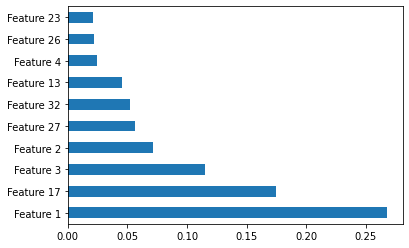

In [ ]:
import matplotlib.pyplot as plt

feat_importances = pd.Series(importances, index=x_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

La prima feature assume un peso molto maggiore di tutte le altre (26.74$\%$). La diciassettesima e la terza feature presentano ancora dei pesi piuttosto elevati mentre tutte le altre hanno un'importanza molto minore nel processo di classificazione.

#**Regressione logistica**

Infine, per confrontare degli algoritmi all'avanguardia al momento della stesura dell'articolo del 2004 con un regressore oggi considerato standard, si opera una classificazione con l'algoritmo *logisticRegressionCV* di SciKitLearn.

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

logreg = LogisticRegressionCV()

start_time = time.time()
logreg.fit(x_train, y_train)
logreg_runtime = time.time() - start_time
logregacc = logreg.score(x_test, y_test)
logregpred = logreg.predict(x_test)

logreg_result = (logreg_runtime, logregacc)
print('{0:<15}{1:<15}'.format("time (s)", "test score"))
print('{0:<15.4f}{1:<15.4f}'.format(*logreg_result))
print('\nConfusion matrix:')
print(confusion_matrix(y_test, logregpred))

time (s)       test score     
120.3282       0.9002         

Confusion matrix:
[[29252  1686]
 [ 2598  9386]]


Il ritulato ottenuto è molto soddisfacente: tramite una regressione logistica di circa 2 minuti, infatti, è stato possibile ottenere un'accuracy sul campione di test del 90.02$\%$, compatibile con l'accuracy massima ottenuta nell'articolo del 2004. <br/>

Si riporta di seguito l'istogramma della probabilità del segnale e del rumore.

In [ ]:
logreg_prob = logreg.predict_proba(x_test)
print(logreg_prob)

[[0.99472963 0.00527037]
 [0.98466944 0.01533056]
 [0.9551754  0.0448246 ]
 ...
 [0.64000201 0.35999799]
 [0.99624401 0.00375599]
 [0.05586409 0.94413591]]


Text(0, 0.5, 'Occorrenze')

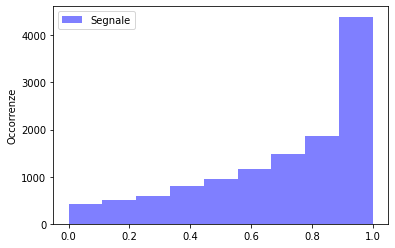

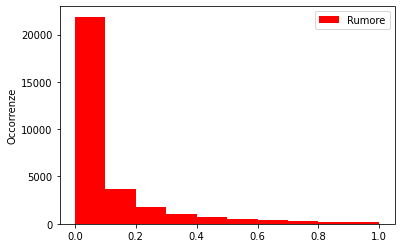

In [ ]:
# grafico delle probabilità delle due classi:
y_test = pd.Series(y_test).values
df_test_acc = pd.DataFrame({'PROB':logreg_prob[:,1]})
df_test_acc['SIG'] = y_test

df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
sighist = df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Segnale')
sighist.set_ylabel('Occorrenze')
bkghist = df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Rumore')
bkghist.set_ylabel('Occorrenze')

Segnale e rumore appaiono molto ben separati, a riprova dell'efficacia della classificazione operata.